<a href="https://colab.research.google.com/github/ali-rehman-ML/robot_traversibility/blob/main/dataSort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading Data

+(imgColorFilesFull, freqListColor, imgDepthFilesFull, freqListDepth)

+(rootPath, csvFiles, topics, csvData, freqList)

### Library Imports and Functions Define

In [ ]:
!pip install pyrealsense2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 12.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import pyrealsense2 as rs
# from pyrealsense2 import rs2_intrinsics
import math
import os
import random
import copy
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [ ]:
def avg(lst): return sum(lst) / len(lst)
def countOccurences(listToCheck):
    listToCheck.sort()
    freq_list=[]
    i=0
    while i < len(listToCheck):
        min_freq=1
        if i+1 < len(listToCheck):
            while listToCheck[i]==listToCheck[i+1]:
                min_freq+=1
                i+=1
                if i+1==len(listToCheck): break
        i+=1
        freq_list.append(min_freq)
    return freq_list
def printSpaces(spaces):
    for i in range(spaces): print(" ", end="")


### Getting Info on Image Data (both RGB & Depth)
+(imgColorFilesFull, freqListColor, imgDepthFilesFull, freqListDepth)

In [ ]:
### Getting names of all the color_image frames
colorPath="/content/drive/MyDrive/Academik Dox/projekt/Wayfast/wayfast1/color"
imgColorFilesFull, imgColorFiles=[f for f in os.listdir(colorPath) if f.endswith('.png')], []
imgColorFilesFull = sorted(imgColorFilesFull)
for i in range(len(imgColorFilesFull)): imgColorFiles.append(int(str(imgColorFilesFull[i])[6:16]))
freqListColor=countOccurences(imgColorFiles)
### Getting names of all the depth_image frames
depthPath="/content/drive/MyDrive/Academik Dox/projekt/Wayfast/wayfast1/depth"
imgDepthFilesFull, imgDepthFiles=[f for f in os.listdir(depthPath) if f.endswith('.png')], []
imgDepthFilesFull = sorted(imgDepthFilesFull)
for i in range(len(imgDepthFilesFull)): imgDepthFiles.append(int(str(imgDepthFilesFull[i])[6:16]))
freqListDepth=countOccurences(imgDepthFiles)
# print(len(imgColorFiles))
# print(freqListColor)
# freqListColor.sort()
# print(freqListColor, '\n')
# print(len(imgDepthFiles))
# print(freqListDepth)
# freqListDepth.sort()
# print(freqListDepth, '\n')

In [ ]:
del imgColorFiles, imgDepthFiles

### Getting Info on Topic Data (CSV Files)
+(rootPath, csvFiles, topics, csvData, freqList)

In [ ]:
rootPath="/content/drive/MyDrive/Academik Dox/projekt/Wayfast/wayfast1/data/"
csvFiles=[f for f in os.listdir(rootPath) if f.endswith('.csv')]        ### Getting names of all the topics available
csvFiles=[f for f in csvFiles if f not in ('_rosout.csv', '_tf.csv', '_imu_node_parameter_updates.csv', '_rosout_agg.csv', '_imu_node_parameter_descriptions.csv', '_diagnostics.csv', '_tf_static.csv', '_odom_gps.csv')]      ### Removing irrelevant topics

topics, csvData, freqList, timeStamps = [], [], [], []
for fileName in csvFiles:
    data = pd.read_csv(rootPath + fileName)
    csvData.append(data)
    topics.append(data.columns.tolist())
    timeStamps = data[topics[-1][0]].tolist()
    for i in range(len(timeStamps)): timeStamps[i] = int(str(timeStamps[i])[:10])
    freq_list=countOccurences(timeStamps)
    freqList.append(list(freq_list))
    # for i in range(len(timeStamps)):
    #     if i < len(timeStamps)-1:
    #         if timeStamps[i] != timeStamps[i+1] and timeStamps[i]+1 != timeStamps[i+1]: print(fileName)
    # print(fileName, '    ', sum(freq_list[0:freq_list.index(min(freq_list))]), '    ', freq_list)
    # freq_list.sort()
    # print(freq_list, '\n')


In [ ]:
# ind = 5
# print(csvFiles[ind])
# print(topics[ind])
# # print(csvData[ind][3])


# # data= pd.read_csv("/content/drive/MyDrive/Academik Dox/projekt/Wayfast/wayfast1/wayfast1/_left_brake_msg.csv")
# # data.columns
# # list1 = data['x']
# # list2 = data['x'].tolist()
# # print(type(list1))
# # print(type(list2))
# # print(list2)


# # print(len(csvFiles), len(topics), len(csvData), len(freqList))
# # for i in range(len(csvFiles)):
# #     print(csvFiles)
# #     print(topics)
# #     print(csvData)

In [ ]:
del timeStamps

# Processing Data

### Downsampling Data
+(csvDataBaseFreq, imgColorBaseFreq, imgDepthBaseFreq)

-(csvData)

In [ ]:
#### Checking if length/timeframe for all topics is same. If not, cutting all topics to match the shortest published topic
baseFreq = 4
valSelected, lenList, r, csvDataBaseFreq = [], [], [], []
for i in range(len(topics)): lenList.append(len(freqList[i])-1) ## finding the number of seconds of published data per topic
minLen = min(lenList)
for i in range(len(topics)): freqList[i] = freqList[i][1:minLen-1] ## adding a window of 1 second on either end and slicing data to make sure all topics are the length of the topic published for the shortest time
#### Downsampling data to Base Frequency
for i in range(len(topics)):
    valSelected.append([0]) #### Adding zero to list initially since first row contains names/headers of published data
    avgVal = int(avg(freqList[i]))
    period = int(avgVal/baseFreq)
    init = random.randint(1,period)
    idx = 0
    for j in range(len(freqList[i])):
        #### Make sure previous iteration did not exceed its time period(its second) which MIGHT happen if values in that second are less than baseFreq
        #### Second condition checks if values in that second are less than baseFreq. if so it starts adding values from pervious second as a buffer
        if idx > sum(freqList[i][0:j]) or freqList[i][j] < baseFreq: continue
        else: idx = init + sum(freqList[i][0:j])
        for k in range(baseFreq): valSelected[i].append(idx+(period*(k)))
    # valSelected[i] = valSelected[i][0:531]
#### Making sure there are no repeated values
for temp in valSelected:
    j=0
    while max(countOccurences(temp))>1:
        for i in range(len(temp)):
            if i+1 < len(temp):
                if temp[i]==temp[i+1]: temp[i]=int((temp[i]+temp[i-1])/2)
                if temp[i]>=sum(freqList[j]): temp[i]=sum(freqList[j])-1
    j+=1
#### creating a new list of data at base frequency. This will be used to generate traversability and new csv file
for i in range(len(valSelected)):
    r.append([])
    r[i]=[j for j in range(len(csvData[i])+1) if j not in valSelected[i]]
for i in range(len(csvFiles)): csvDataBaseFreq.append(pd.read_csv(rootPath+csvFiles[i], skiprows=r[i]))

In [ ]:
#### Doing the same for images
freqListColor = freqListColor[1:minLen-1]
freqListDepth = freqListDepth[1:minLen-1]
imgColorBaseFreq, imgDepthBaseFreq = [], []
#### Color Images
avgVal = int(avg(freqListColor))
period = int(avgVal/baseFreq)
init = random.randint(0,period)
init = 0
idx = 0
for j in range(len(freqListColor)):
    if idx > sum(freqListColor[0:j]) or freqListColor[j] < baseFreq: continue
    else: idx = init + sum(freqListColor[0:j])
    for k in range(baseFreq): imgColorBaseFreq.append(idx+(period*(k)))
#### Depth Images
avgVal = int(avg(freqListDepth))
period = int(avgVal/baseFreq)
init = random.randint(0,period)
init = 0
idx = 0
for j in range(len(freqListDepth)):
    if idx > sum(freqListDepth[0:j]) or freqListDepth[j] < baseFreq: continue
    else: idx = init + sum(freqListDepth[0:j])
    for k in range(baseFreq): imgDepthBaseFreq.append(idx+(period*(k)))

In [ ]:
del csvData,baseFreq,valSelected,lenList,r,avgVal,period,init,idx

### Formatting Data

+(timestamps, trav, path_x, path_y, lin_vel, ang_vel, rgbList, depthList, pathList, muList, nuList)

In [ ]:
os.chdir('/content/drive/MyDrive/Academik Dox/projekt/Wayfast/wayfast1')
contents = os.listdir()
for dir in contents:
    dirPath = Path(dir)
    if dir=="path" or dir=="mu" or dir=='nu':
        !rm -rf {dirPath}
!mkdir path mu nu

#### organizing data to export in a single csv file (csvDataBaseFreq)
## path, Lin_vel, ang_vel, x, y are from ekf/measured odom.
## traversability, mu are from comparing lin_vel_model ang_vel_model with lin_vel and ang_vel
window=10

trav_temp, x_temp, y_temp, lin_vel_temp, ang_vel_temp, lin_vel_model_temp, ang_vel_model_temp, timestamps = [], [], [], [], [], [], [], []
for i in range(len(csvFiles)):
    if csvFiles[i] == '_robot_pose_ekf_odom_combined.csv': x_temp, y_temp = csvDataBaseFreq[i]['x'].tolist(), csvDataBaseFreq[i]['y'].tolist()
    if csvFiles[i] == '_odom_ticks.csv': lin_vel_temp, ang_vel_temp, timestamps = csvDataBaseFreq[i]['x.2'].tolist(), csvDataBaseFreq[i]['z.3'].tolist() , csvDataBaseFreq[i]['rosbagTimestamp'].tolist()
    if csvFiles[i] == '_linVelModel.csv': lin_vel_model_temp = csvDataBaseFreq[i]['data'].tolist()
    if csvFiles[i] == '_angVelModel.csv': ang_vel_model_temp = csvDataBaseFreq[i]['data'].tolist()
#### generate traversability
trav_temp = [a/b if b>0 else 0 for a,b in zip(lin_vel_temp,lin_vel_model_temp)]
trav_temp = np.clip(trav_temp, 0, 0.95)
trav_copy = copy.deepcopy(trav_temp)
for i in range(2, len(trav_temp)-2):
    if (trav_temp[i-2]!=0 or trav_temp[i-1]!=0) and (trav_temp[i+2]!=0 or trav_temp[i+1]!=0): trav_copy[i]=avg(trav_temp[i-2:i+2])
trav_temp=trav_copy
trav, x, y, lin_vel, ang_vel, lin_vel_model, ang_vel_model = [], [], [], [], [], [], []
for i in range(0, len(x_temp)-window):
    timestamps[i] = int(str(timestamps[i])[:10])
    trav.append([[]]), x.append([[]]), y.append([[]]), lin_vel.append([[]]), ang_vel.append([[]]), lin_vel_model.append([[]]), ang_vel_model.append([[]])
    for j in range(window): trav[-1][0].append(trav_temp[i+j]), x[-1][0].append(x_temp[i+j]), y[-1][0].append(y_temp[i+j]), \
                            lin_vel[-1][0].append(lin_vel_temp[i+j]), ang_vel[-1][0].append(ang_vel_temp[i+j]), \
                            lin_vel_model[-1][0].append(lin_vel_model_temp[i+j]), ang_vel_model[-1][0].append(ang_vel_model_temp[i+j])
timestamps, imgDepthBaseFreqTemp, imgColorBaseFreqTemp = timestamps[0:-window], imgDepthBaseFreq[0:-window], imgColorBaseFreq[0:-window]



path_x, path_y = copy.deepcopy(x), copy.deepcopy(y)
for i in range(len(path_x)):
    for j in range(window-1, -1, -1):
        path_x[i][0][j] = path_x[i][0][j] - path_x[i][0][0]
        path_y[i][0][j] = path_y[i][0][j] - path_y[i][0][0]

rgbList, depthList, pathList, muList, nuList = [], [], [], [], []
#### create images for path, mu (product of path and trabersability) and nu
i=0
factor_x, factor_y, alpha = 150, 150, 0.5
for img_no in range(len(path_x)):
    img = np.zeros((240, 424), dtype = "uint8")
    path, mu, nu = img.copy(), img.copy(), img.copy()
    for j in range(window):
        y, x = 212-int(path_y[img_no][0][j]*factor_y/window), np.clip(240-int(path_x[img_no][0][j]*factor_x), 120, 480)
        #### Path
        width, height, colorTrav = int(50*(2-path_x[img_no][0][j]/2)), 10, 255
        cv2.rectangle(path, (y-(width), x-height) , (y+width, x+height), color=(colorTrav, colorTrav, colorTrav), thickness=-1)
        #### Mu
        width, height, colorTrav = int(50*(2-path_x[img_no][0][j]/2)), 10, 255*trav[img_no][0][j]
        cv2.rectangle(mu, (y-(width), x-height) , (y+width, x+height), color=(colorTrav, colorTrav, colorTrav), thickness=-1)
        #### Nu
        width, height, colorTrav = int(50*(2-path_x[img_no][0][j]/2)), 10, 255*0.4
        cv2.rectangle(nu, (y-(width), x-height) , (y+width, x+height), color=(colorTrav, colorTrav, colorTrav), thickness=-1)
        path, mu, nu = cv2.addWeighted(path, alpha, img, 1 - alpha, 0), cv2.addWeighted(mu, alpha, img, 1 - alpha, 0), cv2.addWeighted(nu, alpha, img, 1 - alpha, 0)

    os.chdir('/content/drive/MyDrive/Academik Dox/projekt/Wayfast/wayfast1/path')
    cv2.imwrite("path"+str(timestamps[img_no])+str(i)+".png",path)
    pathList.append(os.getcwd()+"/path"+str(timestamps[img_no])+str(i)+".png")
    os.chdir('/content/drive/MyDrive/Academik Dox/projekt/Wayfast/wayfast1/mu')
    cv2.imwrite("mu"+str(timestamps[img_no])+str(i)+".png",mu)
    muList.append(os.getcwd()+"/mu"+str(timestamps[img_no])+str(i)+".png")
    os.chdir('/content/drive/MyDrive/Academik Dox/projekt/Wayfast/wayfast1/nu')
    cv2.imwrite("nu"+str(timestamps[img_no])+str(i)+".png",nu)
    nuList.append(os.getcwd()+"/nu"+str(timestamps[img_no])+str(i)+".png")
    rgbList.append(colorPath+'/'+str(imgColorFilesFull[imgColorBaseFreqTemp[i]]))
    depthList.append(depthPath+'/'+str(imgDepthFilesFull[imgDepthBaseFreqTemp[i]]))
    i+=1
    if img_no != len(path_x)-2 and img_no != len(path_x)-1:
        if timestamps[img_no]!=timestamps[img_no+1]: i=0
# colorPath+'/'+str(imgColorFilesFull[imgColorBaseFreq[img_no]])

In [ ]:
del contents,window,trav_temp,x_temp,y_temp,lin_vel_temp,ang_vel_temp,lin_vel_model_temp,ang_vel_model_temp,trav_copy,x,y,lin_vel_model,ang_vel_model,imgDepthBaseFreqTemp, imgColorBaseFreqTemp

### Converting Data to CSV and Exporting

In [ ]:
header = ['', , 'path', 'mu', 'nu', 'lin_vel', 'ang_vel', 'x', 'y', 'traversability', 'timestamps']
data = [pathList, muList, nuList, lin_vel, ang_vel, path_x, path_y, trav, timestamps]
timestamps, trav, path_x, path_y, , ang_vel, rgbList, depthList, pathList, muList, nuList

In [ ]:
header = ['Name', 'M1 Score', 'M2 Score']
data = [['Alex', 62, 80], ['Brad',
                           45, 56], ['Joey', 85, 98]]
data = pd.DataFrame(data, columns=header)
data.to_csv('Stu_data.csv', index=False)

### Figuring out Path

[[0.5542785797495319, 0.4472690618044066, 0.44633812969039943, 0.4045643664897232, 0.36280323488923005, 0.47048667506771386, 0.42873305050164184, 0.32172353255651664, 0.32170247606873426, 0.321024347122792]]
[[0.0, 0.08698830219365572, 0.17245798499909215, 0.2986693406912537, 0.3813553513136352, 0.462484563648613, 0.3430299051245731, 0.3842110219734365, 0.546572233905509, 0.6265327721621579]]
[[0.0, 0.07227476625405194, 0.1463395777901907, 0.25969659262039213, 0.3368571267099735, 0.41565369560925747, 0.29519167107696365, 0.33394557644208234, 0.49143088575153027, 0.5714138963591097]]
-234258864.0 -5834213376.0
-40886.36328125 -505444.46875
-346.6372375488281 -3770.976318359375
127.12957000732422 -346.5654602050781
220.04922485351562 145.10702514648438
10.954147338867188 -1121.56298828125
136.3167724609375 -301.08978271484375
246.40225219726562 238.30874633789062
254.666015625 248.177001953125


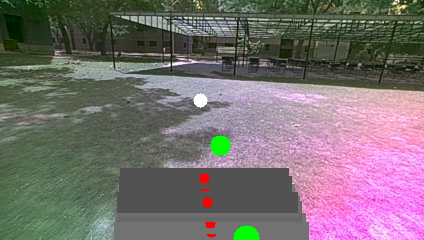

In [ ]:
intrinsics = rs.intrinsics()
intrinsics.width = 424
intrinsics.height = 240
# intrinsics.fx, intrinsics.ppx, intrinsics.fy, intrinsics.ppy = 213.25914001464844, 215.56739807128906, 212.97450256347656, 122.56211853027344
intrinsics.fx, intrinsics.ppx, intrinsics.fy, intrinsics.ppy =  50, 214.4, 100, 122
intrinsics.coeffs = [-0.057378701865673065, 0.06431565433748616, -0.0005341734584327178, 0.0011174276005476713, -0.020352067425847054]
intrinsics.model = rs.distortion.inverse_brown_conrady

factor_x,factor_y, img_no = 100,150, 60

print(trav[img_no])
print(path_x[img_no])
print(path_y[img_no])

a, img = [], cv2.imread(colorPath+'/'+str(imgColorFilesFull[imgColorBaseFreq[img_no]]))
img = cv2.circle(img, (200, 100), radius=7, color=(255, 255, 255), thickness=-1)
for i in range(1, window):
    # a_sq, b_sq, c_sq = (path_x[img_no][0][i])**2, (path_y[img_no][0][i])**2, (0)**2     ## x&y-dist to pt in 2d, camera height
    # z = math.sqrt(a_sq + b_sq + c_sq)
    x,y = rs.rs2_project_point_to_pixel(intrinsics, [path_y[img_no][0][i], 0.9, path_x[img_no][0][i]])
    x,y = np.nan_to_num(x,nan=240), np.nan_to_num(y,nan=212)
    # x,y = rs.rs2_project_point_to_pixel(intrinsics, [path_x[img_no][0][i], path_y[img_no][0][i], 1])
    print(x,y)
    if x>=0 and x<=424 and y>=0 and y<=240: img = cv2.circle(img, (int(x), int(y)), radius=i+5, color=(0, 255, 0), thickness=-1)

    y, x = 212-int(path_y[img_no][0][i]*factor_y/window), 240-int(path_x[img_no][0][i]*factor_x)
    x = np.clip(x, 120, 480)
    width, height, colorTrav = int(50*(2-path_x[img_no][0][i]/2)), 10, 255*trav[img_no][0][i]
    cv2.rectangle(img, (y-(width), x-height) , (y+width, x+height), color=(colorTrav, colorTrav, colorTrav), thickness=-1)
    img = cv2.circle(img, (int(y),int(x)), radius=5, color=(0, 0, 255), thickness=-1)
cv2_imshow(img)
plt.show()

# img = cv2.imread(depthPath+'/'+str(imgDepthFilesFull[imgDepthBaseFreq[img_no]]))
# cv2_imshow(img)
# plt.show()

In [ ]:
# print(max(valSelected[10]))
# print(sum(freqList[10]))
# print(len(r[1]))
# tab1 = 40
# tab2 = 4
# for i in range(len(csvDataBaseFreq)):
#     print(csvFiles[i], end="")
#     printSpaces(tab1-len(csvFiles[i]))
#     print(len(valSelected[i]), "\t", len(csvDataBaseFreq[i]), "\t", len(freqList[i]), "\t", len(csvData[i]), "\t")

# print(freqListColor)
# print(freqListColor)
# print(len(imgColorBaseFreq), imgColorBaseFreq)
# print(freqListDepth)
# print(len(imgDepthBaseFreq), imgDepthBaseFreq)



# print(len(x_temp), x_temp)
# print(len(x), x)
# temp = pd.DataFrame(x)
# # temp.to_csv("temp_test.csv")
# print(temp)
# print(csvFiles)